# Transfer Learning - the smarter way

In [1]:
import os
import pandas as pd
import preprocess
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import util

# rewrite to not use keras
import tensorflow as tf

vgg16 = tf.contrib.keras.applications.vgg16
#keras.applications import vgg16
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 preprocess_input, decode_predictions

np.random.seed(42)


In [4]:
vgg16_benchmark = vgg16.VGG16(weights='imagenet')

553418752/553467096 [============================>.] - ETA: 0s

In [5]:
#4 Breed I chose fo fun
BREEDS = ['scottish_deerhound', 'maltese_dog', 'pomeranian', 'cocker_spaniel']
DATA_DIR_PATH = preprocess.DATA_DIR_PATH
NUM_CLASSES = 120
labels = pd.read_csv(os.path.join(preprocess.DATA_DIR_PATH, 'labels.csv'))

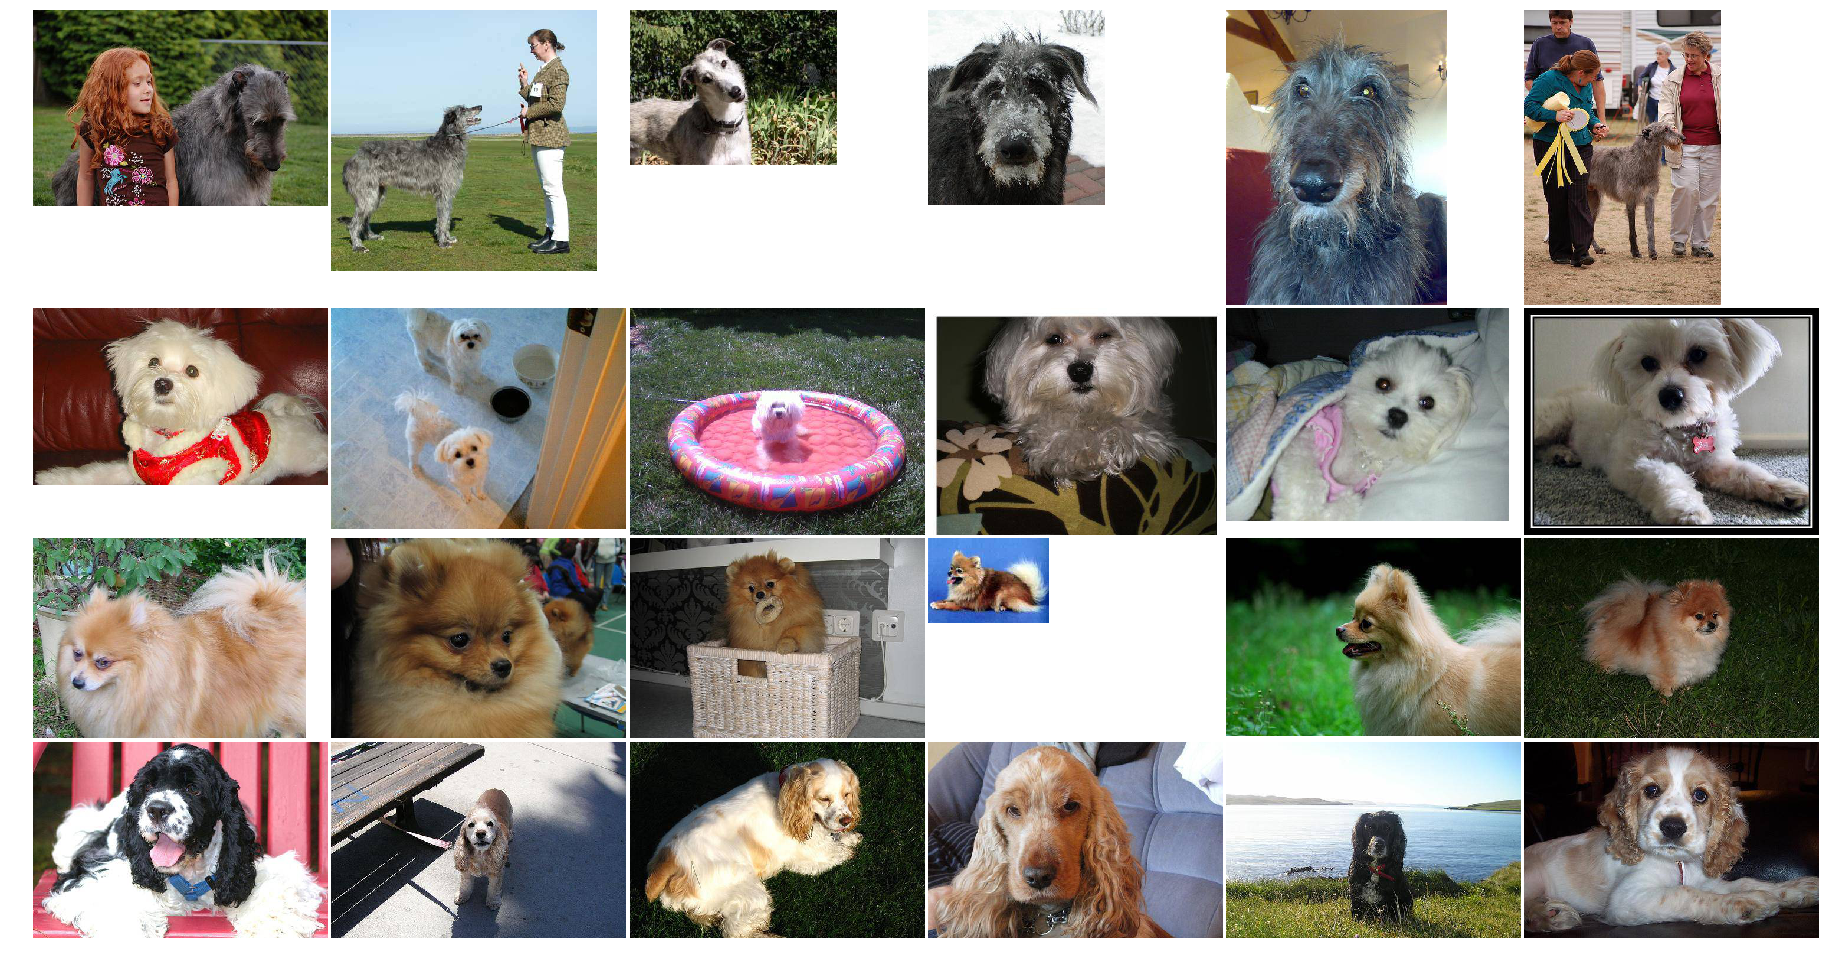

In [10]:
NUM_SAMPLE_PER_BREED = 6

fig = plt.figure(1, figsize=(32, 32))
grid = ImageGrid(fig, 111, nrows_ncols=(len(BREEDS), NUM_SAMPLE_PER_BREED), axes_pad=0.05)

idx = 0
for breed in BREEDS:
    for img_id in labels[labels.breed == breed].id.tolist()[:6]:
        ax = grid[idx]
        #print(img_id)
        img = util.read_image_as_rbg(img_id=img_id)
        ax.imshow(img)
        ax.axis('off')
        idx += 1
plt.show()

In [11]:
x_train_list_id = []
y_train_labels = None
BREED_TO_IDX_MAP = { breed:idx for idx, breed in enumerate(BREEDS)}
IDX_TO_BREED_MAP = { idx:breed for idx, breed in enumerate(BREEDS)}

for idx, breed in enumerate(BREEDS):
    BREED_TO_IDX_MAP[breed] = idx
    breed_list = labels[labels.breed == breed].id.tolist() 
    num_ids = len(breed_list)
    
    breed_y = np.zeros((len(breed_list), len(BREEDS)))
    breed_y[:, idx] = 1 #mark response for this breed at this index
    
    
    x_train_list_id.extend( breed_list )
    
    print(len(breed_list), breed_y.shape)

    if y_train_labels is None:
        y_train_labels = breed_y
    else:
        y_train_labels = np.vstack( (y_train_labels, breed_y) )

        
print(BREED_TO_IDX_MAP)
print(IDX_TO_BREED_MAP)
print(len(x_train_list_id), y_train_labels.shape, y_train_labels.sum(axis = 0))

126 (126, 4)
117 (117, 4)
111 (111, 4)
74 (74, 4)
{'scottish_deerhound': 0, 'maltese_dog': 1, 'pomeranian': 2, 'cocker_spaniel': 3}
{0: 'scottish_deerhound', 1: 'maltese_dog', 2: 'pomeranian', 3: 'cocker_spaniel'}
428 (428, 4) [ 126.  117.  111.   74.]


In [12]:
NUM_SAMPLES = 428

idx_arr =  np.arange(NUM_SAMPLES)
np.random.shuffle(idx_arr)
print('sample of random array', idx_arr[:25])

train_arr = idx_arr[:int(NUM_SAMPLES * 0.8)]
valid_arr = idx_arr[int(NUM_SAMPLES * 0.8):]

sample of random array [420  75 177  30 362 271 155 152 165 175 410  70 196 417  39 141 351  72
   9 403 297 220 374  55 140]


In [13]:
x_train = util.get_image_matrix_from_ids(x_train_list_id, output_size = (224, 224))

X_train_arr = x_train[train_arr]
X_valid_arr = x_train[valid_arr]

y_train_arr = y_train_labels[train_arr]
y_valid_arr = y_train_labels[valid_arr]

print(X_train_arr.shape, y_train_arr.shape)
print(y_train_arr.sum(axis = 0))

print(y_valid_arr.sum(axis = 0))

#[ 103.   95.   83.   61.]
#[ 23.  22.  28.  13.]

(342, 224, 224, 3) (342, 4)
[ 103.   95.   83.   61.]
[ 23.  22.  28.  13.]


cocker_spaniel


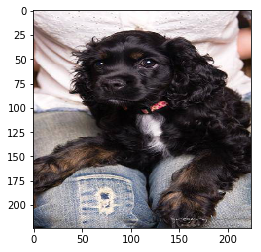

scottish_deerhound


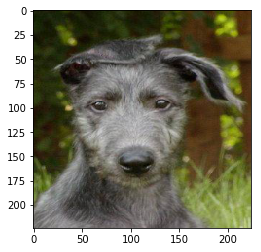

maltese_dog


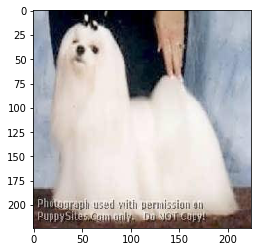

scottish_deerhound


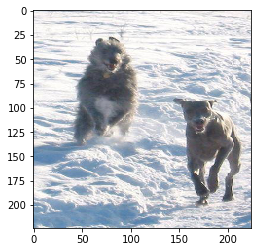

cocker_spaniel


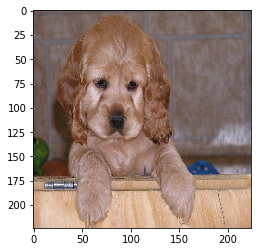

pomeranian


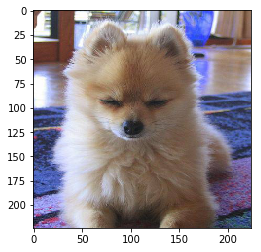

maltese_dog


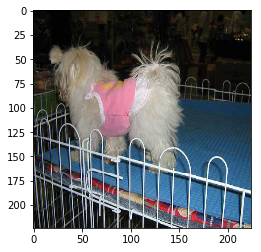

maltese_dog


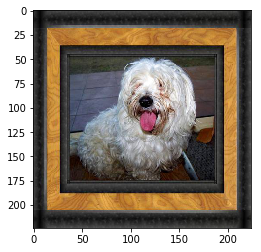

maltese_dog


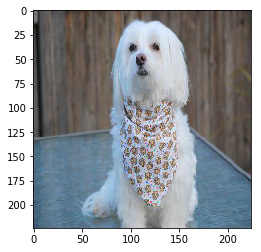

maltese_dog


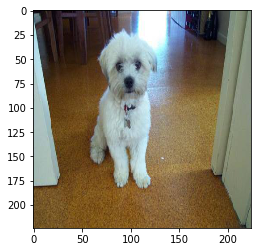

cocker_spaniel


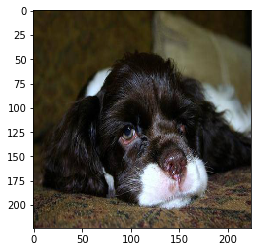

scottish_deerhound


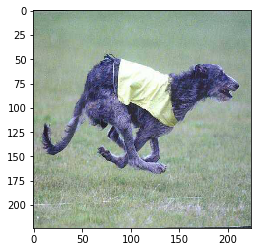

maltese_dog


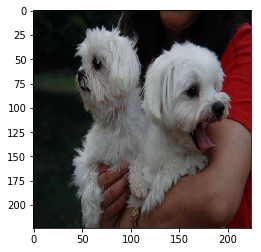

cocker_spaniel


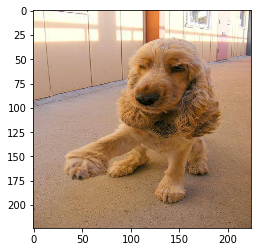

scottish_deerhound


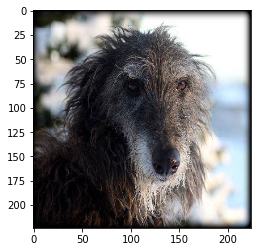

maltese_dog


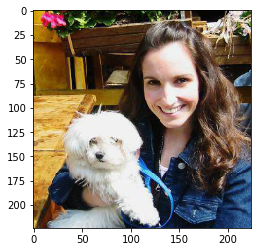

pomeranian


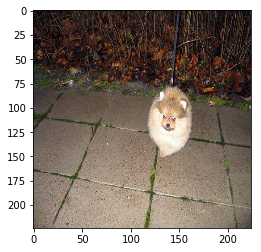

scottish_deerhound


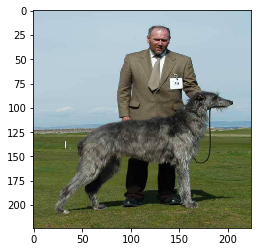

scottish_deerhound


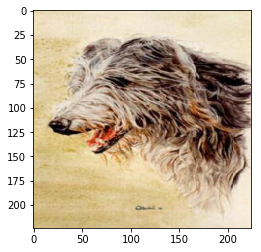

cocker_spaniel


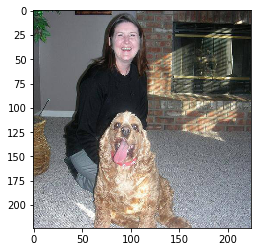

In [14]:
for i in range(20):
    print(util.decode_arr(y_train_arr[i], BREEDS))
    plt.imshow(X_train_arr[i].astype('uint8'))
    plt.show()


 # VGG16 predictive accuracy on 4 classes

In [15]:
vgg16_benchmark = vgg16.VGG16(weights='imagenet')

In [16]:
X_valid_arr_pp = vgg16.preprocess_input(X_valid_arr.copy())

In [17]:
valid_vgg_preds = vgg16_benchmark.predict(X_valid_arr_pp, batch_size=32, verbose=1)

86/86 [==============================] - 41s     


24576/35363 [===================>..........] - ETA: 0sPredicted:  cairn 0.432123
Actual:  maltese_dog


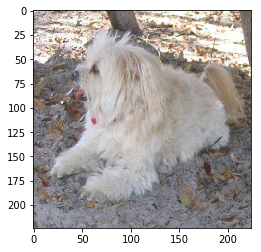

Predicted:  Irish_wolfhound 0.64508
Actual:  scottish_deerhound


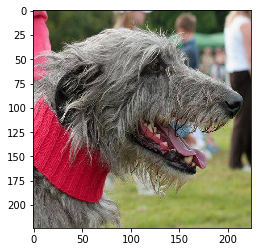

Predicted:  Airedale 0.276274
Actual:  cocker_spaniel


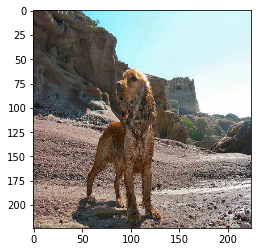

Predicted:  Irish_wolfhound 0.291231
Actual:  scottish_deerhound


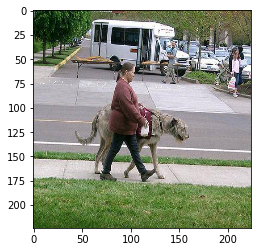

Predicted:  Irish_wolfhound 0.971563
Actual:  scottish_deerhound


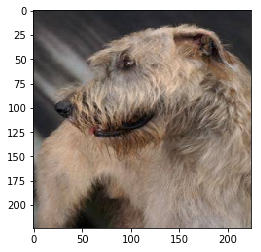

Predicted:  Irish_wolfhound 0.711029
Actual:  scottish_deerhound


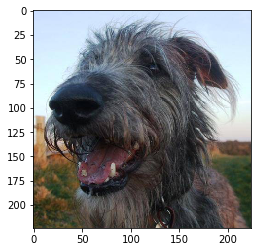

Predicted:  West_Highland_white_terrier 0.535827
Actual:  maltese_dog


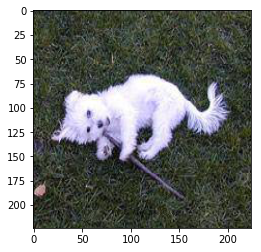

Predicted:  Old_English_sheepdog 0.625224
Actual:  maltese_dog


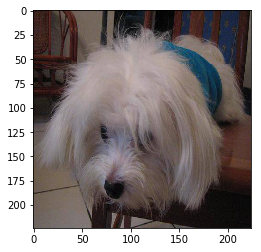

Predicted:  Gordon_setter 0.586885
Actual:  cocker_spaniel


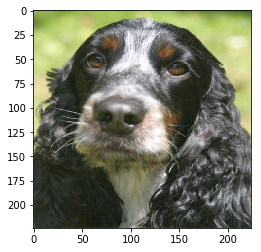

Predicted:  Irish_water_spaniel 0.511257
Actual:  cocker_spaniel


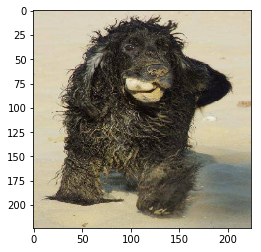

Predicted:  English_setter 0.0622535
Actual:  scottish_deerhound


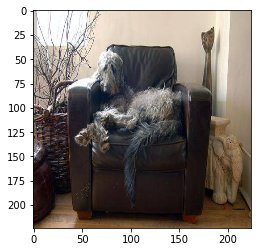

Predicted:  Afghan_hound 0.105051
Actual:  scottish_deerhound


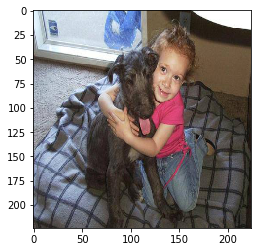

Accuracy:  0.8604651162790697


In [18]:
NUMBER_CASES = X_valid_arr.shape[0]
MISS_CASES = 0.0

for i, pred in enumerate(vgg16.decode_predictions(valid_vgg_preds, top=1)):
    actual_cls = util.decode_arr(y_valid_arr[i], BREEDS)
    if actual_cls != pred[0][1].lower():
        MISS_CASES += 1.0
        print('Predicted: ', pred[0][1], pred[0][2])
        print('Actual: ', actual_cls)
        plt.imshow(X_valid_arr[i].astype('uint8'))
        plt.show()

print('Accuracy: ', (NUMBER_CASES - MISS_CASES)/NUMBER_CASES) #51%?

In [19]:
X_train_arr_pp = vgg16.preprocess_input(X_train_arr.copy())

In [20]:

print((X_train_arr_pp.shape, X_valid_arr_pp.shape, y_train_arr.shape, y_valid_arr.shape))
vgg_bottleneck = vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')

train_vgg_bf = vgg_bottleneck.predict(X_train_arr_pp, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(X_valid_arr_pp, batch_size=32, verbose=1)

print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((342, 224, 224, 3), (86, 224, 224, 3), (342, 4), (86, 4))
86/86 [==============================] - 40s     
VGG train bottleneck features shape: (342, 512) size: 175,104
VGG valid bottleneck features shape: (86, 512) size: 44,032


In [23]:
import sklearn

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

In [26]:
lr.fit(train_vgg_bf, y_train_arr.argmax(axis = 1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
valid_preds = lr.predict(valid_vgg_bf)

In [28]:
(valid_preds == y_valid_arr.argmax(axis=1)).mean()

0.98837209302325579

In [29]:
valid_preds

array([1, 1, 2, 3, 2, 3, 3, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 0, 3, 0, 0,
       1, 0, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 1, 2, 3, 1, 2, 3, 2, 2, 0,
       3, 0, 1, 1, 3, 1, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2, 1, 3, 2, 2, 2, 2, 1,
       1, 1, 3, 0, 3, 0, 2, 1, 0, 3, 0, 1, 0, 0, 2, 2, 0], dtype=int64)

prediction:  scottish_deerhound
actual:  cocker_spaniel


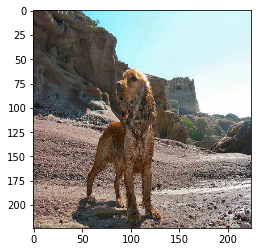

In [30]:
for i in range(X_valid_arr.shape[0]):
    pred_cls = IDX_TO_BREED_MAP[valid_preds[i]]
    act_cls = util.decode_arr(y_valid_arr[i], BREEDS)
    if pred_cls != act_cls:
        img = X_valid_arr[i].astype('uint8')
        print('prediction: ', pred_cls)
        print('actual: ', act_cls)
        
        plt.imshow(img)
        plt.show()
        